In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

#Import DeepLift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Build and train a network.

SKIP_TRAIN = True
saved_model_file = 'model.h5'

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_train])
x_test = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_test])



x_train = x_train.reshape(-1, img_rows,img_cols,1)
x_test = x_test.reshape(-1, img_rows,img_cols,1)
#x_train = x_train.reshape(-1, img_rows*img_cols)
#x_test = x_test.reshape(-1, img_rows*img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
reg = keras.regularizers.l1(0)
def f(x):
    return x*tf.sigmoid(x)

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    #de.enable_override('shapley')
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), input_shape=(28,28,1)))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(20, input_shape=(img_rows*img_cols,), activation='relu', bias_regularizer=reg))
    model.add(Dense(10, activation='relu', bias_regularizer=reg))
    model.add(Dense(num_classes, bias_regularizer=reg))
    model.add(Activation('softmax'))
    # ^ IMPORTANT: notice that the final softmax must be in its own layer 
    # if we want to target pre-softmax units

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    #print (model.layers[0].get_weights()[1].mean())
    #print (model.layers[0].get_weights()[1].var())
model.summary()   
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                108180    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
act

In [4]:
%matplotlib inline
aModel = Model(inputs=model.inputs, outputs=[model.layers[1].input])
y = aModel.predict(x_test)
import matplotlib.pyplot as plt
#plt.hist(model.layers[1].get_weights()[0].flatten(), 100)
#plt.hist(y.flatten(), 100)

In [3]:
# Define what to be explained
xs = x_test[0:5]
ys = y_test[0:5]
a_gradin = np.zeros_like(xs)
a_intgrad = np.zeros_like(xs)
a_res = np.zeros_like(xs)
a_rc = np.zeros_like(xs)
a_shap = np.zeros_like(xs)
a_shaplud = np.zeros_like(xs)
a_exact = np.zeros_like(xs)


In [4]:
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])
print (a_rc.shape)

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
(5, 1, 28, 28, 1)


In [4]:
%time
input_tensor = model.layers[0].input
grad_original = xs * K.gradients(model.layers[-2].output*ys, [input_tensor])[0]
max_pool_grad_original = K.function([input_tensor], [grad_original])([xs])[0]
print (max_pool_grad_original.shape)

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    

    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    #a_res = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    #a_linear = de.explain('linear', target_tensor * ys, input_tensor, xs)
    a_shap = de.explain('shapley', target_tensor * ys, input_tensor, xs)
    #a_shap = np.zeros_like(a_linear)
    
    #attributions2 = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")
print (max_pool_grad_original[0])
print ('Override')
print (a_shap[0])
print (np.sum((max_pool_grad_original - a_shap)**2))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs
(5, 28, 28, 1)
{'Relu': 'DeepExplainGrad', 'MaxPool': 'MaxPoolDeepExplainGrad', 'Softplus': 'DeepExplainGrad', 'Sigmoid': 'DeepExplainGrad', 'Tanh': 'DeepExplainGrad', 'Elu': 'DeepExplainGrad'}
DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
maxpool
name: "model_1/max_pooling2d_1/MaxPool"
op: "MaxPool"
input: "model_1/conv2d_1/Relu"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "_gradient_op_type"
  value {
    s: "MaxPoolDeepExplainGrad"
  }
}
attr {
  key: "data_format"
  value {
    s: "NHWC"
  }
}
attr {
  key: "ksize"
  value {
    list {
      i: 1
      i: 2
      i: 2
      i: 1
    }
  }
}
attr {
  key: "padding"
  value {
    s: "VALID"
  }
}
attr {
  key: "strides"
  value {
    list {
      i: 1
      i: 2
      i: 2
      i: 1
    }
  }
}

Tensor("gradients_1/model_1/flatten_1/Reshape_grad/Reshape:0", shape=(?, 13, 13, 32), dtype=float32)
Tensor(

AssertionError: (27040, 4, 1)

In [6]:
from utils import plot, plt
%matplotlib inline

def extract_patches(x):
    return tf.extract_image_patches(
        x,
        (1, 3, 3, 1),
        (1, 1, 1, 1),
        (1, 1, 1, 1),
        padding="VALID"
    )

def extract_patches_inverse(x, y):
    _x = tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = tf.gradients(_y, _x)[0]
    result =  tf.gradients(_y, _x, grad_ys=y)[0] / grad
    result = tf.check_numerics(
    result,
    'result contains nans',
    )
    return result

images = 100 * np.random.random((1, 28, 28, 1)).astype(np.float32)
patches = extract_patches(images)
print ("Patches: ", patches.shape)
images_reconstructed = extract_patches_inverse(images, patches) # notice that images is only passed to the the right shape
print (images_reconstructed)

images_reconstructed = images_reconstructed.eval(session=K.get_session())

print (np.sum(np.square(images - images_reconstructed)))
return

print (patches.shape)
kernel = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]
print (kernel.shape)
print (bias.shape)
patches = tf.reshape(patches, (-1, 9))
_kernel = kernel.reshape(-1, 32)
result = tf.matmul(patches,_kernel)
print (result.shape)
result = tf.reshape(result, (1, 26, 26, 32))
print (result.shape)

conv = tf.nn.conv2d(
    xs,
    kernel,
    (1, 1, 1, 1),
    "VALID",
    use_cudnn_on_gpu=True,
    data_format='NHWC',
    dilations=[1, 1, 1, 1],
)
print (conv.shape)

print (tf.reduce_sum(tf.square(conv - result)).eval(session=K.get_session()))


Patches:  (1, 26, 26, 9)
Tensor("CheckNumerics_1:0", shape=(1, 28, 28, 1), dtype=float32)
7.0337522e-09


SyntaxError: 'return' outside function (<ipython-input-6-fa3c54c5fecf>, line 33)

In [6]:
import shap
import numpy as np
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
# background = np.zeros_like(background)

# explain predictions of the model on four images
e = shap.DeepExplainer((model.layers[0].input, model.layers[-2].output), background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(xs)
y_ = np.argmax(ys, 1)
npshap = np.array(shap_values)
#npshap = npshap.reshape(10, 15, -1)
#shap_values = np.transpose(shap_values, (1, 0, 2, 3, 4))
a_shaplud = np.array([npshap[item, enum] for enum, item in enumerate(y_)])
print (a_shaplud.shape)

# plot the feature attributions
#shap.image_plot(shap_values, -xs)

[MOD] for Tensorflow 1.7.0


/home/anconam/projects/DeepExplain/src/shap/shap/explainers/deep.py:81: UserWarning: Your TensorFlow version is older than 1.8.0 and not supported.
  warnings.warn("Your TensorFlow version is older than 1.8.0 and not supported.")


(5, 28, 28, 1)


In [13]:
# Compute exacly shapley values!
saved_file = 'exact.npy'
if True or not SKIP_TRAIN:
    from deepexplain.tensorflow.exact_shapley import compute_shapley
    a_exact = np.array([compute_shapley(xx, lambda x: (fModel.predict(np.array(x))*yy).sum(-1)) for xx, yy in zip(xs, ys)])
    np.save(saved_file, a_exact)
else:
    a_exact = np.load(saved_file)


Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)
Exact Shapley (v2)
(16,)


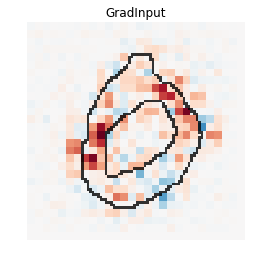

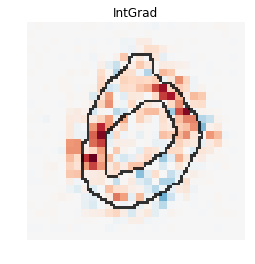

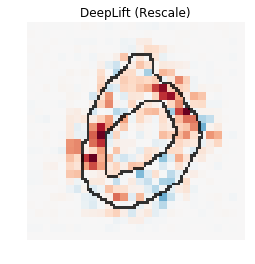

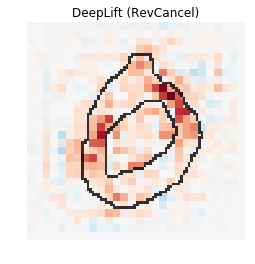

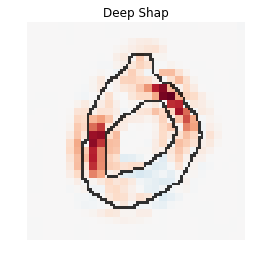

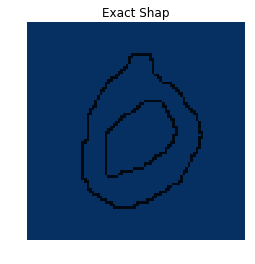

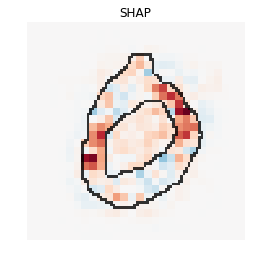

In [10]:
# Plot attributions
from utils import plot, plt
%matplotlib inline
idx = 3
plot(a_gradin[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('GradInput')
plt.figure()
plot(a_intgrad[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('IntGrad')
plt.figure()
plot(a_res[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (Rescale)')
plt.figure()
#plot((a_linear)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Linear')
#plt.figure()
plot(a_rc[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (RevCancel)')
plt.figure()
plot((a_shap)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Deep Shap')
plt.figure()
plot((a_exact)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Exact Shap')
plt.figure()
plot((a_shaplud)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('SHAP')



        
        


Diff with DeepShap  0.17299335931414067
Diff with DeepLift  0.36451434251638587
Diff with DeepLift (Rescale)  1.3798387257274352
Diff with Int Gradients  1.3905515371525725
Diff with GradInput  4.08375209688684
Pearson with DeepShap  0.9859803921568627
Pearson with DeepLift  0.9749019607843136
Pearson with DeepLift (rescale) 0.9823529411764705
Pearson with Int Gradients  0.9814705882352942
Pearson with GradInput  0.9505882352941176


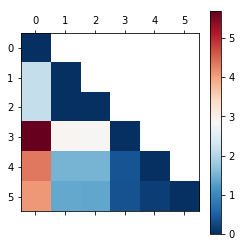

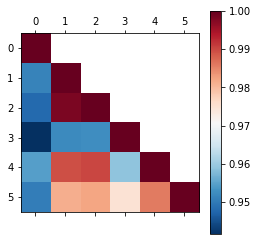

In [22]:
methods = [a_gradin, a_intgrad, a_res, a_rc, a_shap, a_exact]
confusion = np.zeros((len(methods), len(methods)))
confusion[:] = np.nan
confusion_r = np.zeros((len(methods), len(methods)))
confusion_r[:] = np.nan

n = a_gradin.shape[0]
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        if i >= j:
            m1 = m1.reshape(n, -1)
            m2 = m2.reshape(n, -1)
            confusion[i][j] = ((m1-m2)**2).mean()
            confusion_r[i][j] = np.mean([scipy.stats.spearmanr(x, y)[0] for x,y in zip(m1, m2)])
plt.figure()
plt.matshow(confusion, cmap='RdBu_r')
plt.colorbar()
plt.figure()
plt.matshow(confusion_r, cmap='RdBu_r')
plt.colorbar()
print ('Diff with DeepShap ', confusion[-1][-2])
print ('Diff with DeepLift ', confusion[-1][-3])
print ('Diff with DeepLift (Rescale) ', confusion[-1][-4])
print ('Diff with Int Gradients ', confusion[-1][-5])
print ('Diff with GradInput ', confusion[-1][-6])


print ('Pearson with DeepShap ', confusion_r[-1][-2])
print ('Pearson with DeepLift ', confusion_r[-1][-3])
print ('Pearson with DeepLift (rescale)', confusion_r[-1][-4])
print ('Pearson with Int Gradients ', confusion_r[-1][-5])
print ('Pearson with GradInput ', confusion_r[-1][-6])

In [11]:
from deepexplain.tensorflow.accuracy_robustness import run_robustness_test
original_maps = [a_gradin, a_intgrad, a_res, a_rc, a_shap, a_shaplud]
names = ['GradInput', 'IntGrad', 'DeepLift (Recale)', 'DeepLift (RevCanc)', 'ApprShapley', 'SHAP']
run_robustness_test(fModel, xs, ys, original_maps, names, 'Test', 1,
                        result_path='.', mode='prediction', reduce_dim=None)



Running robustness test...
Storing robustness results...
Done


In [ ]:
from deepexplain.tensorflow.sensitivityn import run_sensitivity_test
run_sensitivity_test(fModel, xs, ys, original_maps, names, 'Test',
                        result_path='.', number_of_samples=1000)
